In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


폰트가 없어서 뜨는 경고 문구 때문에 설치 했음.

In [2]:
!apt-get update -y
!apt-get install -y fonts-nanum fonts-noto-cjk fontconfig
!fc-cache -fv

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,425 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd6

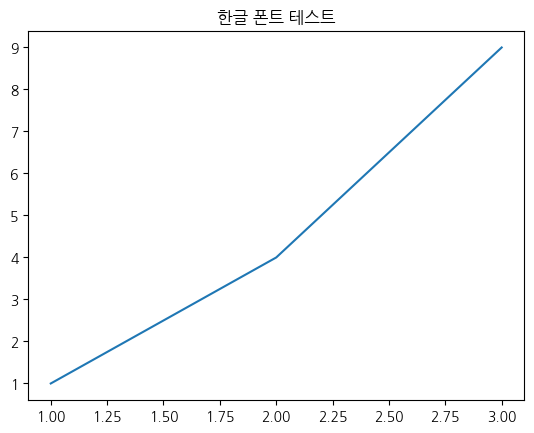

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Nanum Gothic 강제로 등록
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
mpl.font_manager.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

# 테스트
plt.plot([1,2,3], [1,4,9])
plt.title("한글 폰트 테스트")
plt.show()


In [4]:
import matplotlib.font_manager as fm

fonts = sorted({f.name for f in fm.fontManager.ttflist})
print([f for f in fonts if "Nanum" in f or "Noto" in f])

['NanumGothic']


In [5]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "NanumGothic"  # 또는 "Noto Sans CJK KR"
mpl.rcParams["axes.unicode_minus"] = False


필요한 라이브러리 설치

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 업로드 할 파일들은 이 셀에 코드 작성하기
dataset = pd.read_excel("/content/drive/MyDrive/df.xlsx")
df_control = pd.read_excel("/content/drive/MyDrive/제주태양광출력제한_워크시트.xlsx")

In [ ]:
df = dataset.copy()
# dataset은 그대로 보존하고 df로 copy하여 이용하고자 함.
df = df.drop_duplicates(subset=["Datatime", "발전소명"])
df.reset_index(drop=True, inplace=True)
df.describe()

# 1. dataset 정리하기

**[데이터셋 설명]**\
df:
18개 발전소의 데이터를 포함하며, 각 발전소의 경사면 일사량, 인버터별 발전량 및 발전량 합계, 모듈 온도와 외기 온도 정보를 담고 있습니다. 또한, 기상청 자료를 활용하여 강수량, 풍속, 습도, 태양 고도 등 기상 요소도 추가로 포함하였습니다.
또한, 발전소별 고유 정보인 위치, 인버터 수량 및 모델, 모듈 종류 등 시간에 따라 변하지 않는 정적 속성들을 포함하고 있습니다.

df_control:
출력 제한 관련 정보를 담고 있는 워크시트로부터 추출된 데이터로, 각 발전소별 출력 제한이 발생한 시점과 기간 등의 정보를 포함합니다.

- 출력제한 내역을 라벨링 하는 것까지 포함하기
- 고장내역들도 일단 추가하기

Datatime은 시간 정보가 인덱스에 있어야 해서 타입을 바꿔줘야 하는 것 같음.\
df.info()를 통해 확인한 결과 숫자형이 아닌 문자형으로 표시 되는 몇 가지가 있음\
엑셀에 숫자지만 문자로 인식한 열들을 정리하기 위한 코드\
[경사면일사량, INV0001_발전량, INV0002_발전량, 발전량합계]


In [ ]:
df['Datatime'] = pd.to_datetime(df['Datatime'])
df["경사면일사량"] = pd.to_numeric(df["경사면일사량"], errors="coerce").fillna(0)
df['INV0001_발전량'] = pd.to_numeric(df['INV0001_발전량'], errors='coerce').fillna(0)
df['INV0002_발전량'] = pd.to_numeric(df['INV0002_발전량'], errors='coerce').fillna(0)
df['발전량합계'] = df['INV0001_발전량'] + df['INV0002_발전량']

# erroes = 'coerce' / 숫자로 변환할 수 없으면 Nan 값으로 처리

In [ ]:
df.info()

In [ ]:
df.describe()

**출력제한내역 라벨링하기**\
출력제한에 포함되는 시간대는 1로 아닌 시간대는 0으로 라벨링을 먼저하고 진행하기

In [ ]:
from datetime import timedelta
import pandas as pd

def parse_control_interval(row):
    date = row['출력제한일'].date()
    start_str, end_str = row['정지시간(통보문자)'].split('~')
    start = pd.to_datetime(f"{date} {start_str}")
    end   = pd.to_datetime(f"{date} {end_str}")
    return start, end

# 1) 전체 mask 초기화 → 기본은 0 (출력제한 없음)
df["출력제한여부"] = 0

# 2) 발전소별로 제어구간 + 인접 1시간 블록 체크
for _, ctl in df_control.iterrows():
    plant = ctl['발전소명']
    start, end = parse_control_interval(ctl)

    cond = (
        (df['발전소명'] == plant) &
        (df['Datatime'] < end) &
        ((df['Datatime'] + timedelta(hours=1)) > start)
    )

    # 조건을 만족하는 행 → 1로 라벨링
    df.loc[cond, "출력제한여부"] = 1

# 3) 결과 확인
print(df["출력제한여부"].value_counts())

**고장내역에 있는 것들 라벨링하기**

먼저 고장내역 워크시트 불러오기

In [ ]:
df_fault = pd.read_excel("/content/drive/MyDrive/fault_windows.xlsx", dtype=str)

In [ ]:
# 2) datetime 형변환
df_fault["start"] = pd.to_datetime(df_fault["start"])
df_fault["end"]   = pd.to_datetime(df_fault["end"])

# df도 Datatime 열을 datetime으로 변환
df["Datatime"] = pd.to_datetime(df["Datatime"])

# 3) 기본 라벨 0으로 초기화
df["고장내역여부"] = 0

# 4) 발전소별, 구간별로 라벨링
for _, row in df_fault.iterrows():
    plant = row["발전소명"]
    start = row["start"]
    end   = row["end"]

    cond = (
        (df["발전소명"] == plant) &
        (df["Datatime"] >= start) &
        (df["Datatime"] <= end)
    )
    df.loc[cond, "고장내역여부"] = 1

print(df["고장내역여부"].value_counts())

# **2. 모듈 온도 전처리**

외기 온도의 이상치는 온도로 대체하고 모듈 온도의 이상치는 외기 온도 추정치 공식을 사용해 보간하는 것으로 함.

In [ ]:
mask = (df["외기온도(°C)"].isna()) | (df["외기온도(°C)"] > 60)
df.loc[mask, "외기온도(°C)"] = df.loc[mask, "온도"]
df['외기온도(°C)'].describe()

이제 모듈 온도 추정 공식을 사용하여 '모듈온도(°C)' 이상치를 전부 정상 값으로 대체하고자 함.


> 모듈 온도 추정 공식 : T_module = T_air + [(NOCT - 20) / 800] × G


T_module	모듈 온도 (°C) → 우리가 추정하고 싶은 값\
T_air : 외기온도 (°C) → 데이터 없으면 기상청 평균값 or 고정값 사용 가능\
NOCT : Nominal Operating Cell Temperature, 보통 45~48°C\
G : 일사량 (W/m²)\
800 : 기준 일사량 (정상조건)\
출력 보정 값 : P_actual = P_STC × [1 + γ × (T_module - 25)]
P_actual : 실제 발전량 (보정 후)
P_STC : 정격 출력 (STC 기준)

γ : 온도 계수(Pmax), 예: -0.00394 (≒ -0.394%/°C)
T_module : 위에서 추정한 모듈 온도

In [ ]:
module_specs = {
    'SN375M-32': {
        'NOCT': 45.0,
        'alpha': -0.00394  # Pmpp 온도 계수
    },
    'SN390M-37': {
        'NOCT': 46.5,
        'alpha': -0.00350  # Pmpp 온도 계수
    }
}

def estimate_module_temp(row):
    module_name = row['모듈명']
    T_air = row['외기온도(°C)']
    G = row['경사면일사량']

    if pd.isna(T_air) or pd.isna(G):
        return np.nan  # 외기온도 또는 일사량이 없으면 추정 불가

    NOCT = module_specs.get(module_name, {}).get('NOCT', 46.0)  # 모듈명 없으면 기본 46.0 사용
    T_module = T_air + ((NOCT - 20) / 800) * G
    return T_module

모듈 온도가 -40 ~ 85 사이가 아닌 것들의 데이터를 따로 저장해서 인싸이트 도출하기

In [ ]:
import pandas as pd

# 1️⃣ 마스크 조건 정의
mask_1 = (
    df['모듈온도(°C)'].isna() |
    (df['모듈온도(°C)'] < -40) |
    (df['모듈온도(°C)'] > 100)
)

# 2️⃣ 조건에 해당되는 행만 추출
df_outliers = df[mask_1].copy()

# 3️⃣ 엑셀 파일로 저장
df_outliers.to_excel("모듈온도_이상치.xlsx", index=False)

In [ ]:
# 이상치 조건: 결측 or -40도 미만 or 85도 초과
mask = df['모듈온도(°C)'].isna() | (df['모듈온도(°C)'] < -40) | (df['모듈온도(°C)'] > 85)

# 추정값 계산 후 대체
df.loc[mask, '모듈온도(°C)'] = df.loc[mask].apply(estimate_module_temp, axis=1)

df['모듈온도(°C)'].describe()
#이게 아마 일사량을 이상치를 처리하지 않아서 생긴 문제 같음.

In [ ]:
df_outliers.info()

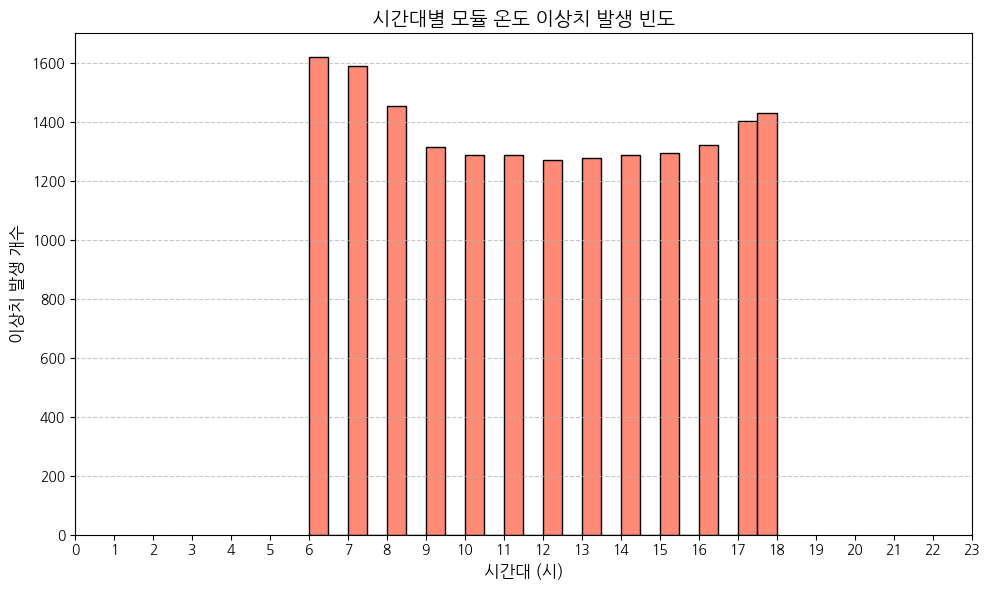

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime 컬럼이 datetime 형식이 아닐 경우 변환
df_outliers["Datatime"] = pd.to_datetime(df_outliers["Datatime"])

# 시간(hour)만 추출
df_outliers["hour"] = df_outliers["Datatime"].dt.hour

# 시각화
plt.figure(figsize=(10,6))
sns.histplot(df_outliers["hour"], bins=24, color="tomato", kde=False)

plt.title("시간대별 모듈 온도 이상치 발생 빈도", fontsize=14)
plt.xlabel("시간대 (시)", fontsize=12)
plt.ylabel("이상치 발생 개수", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

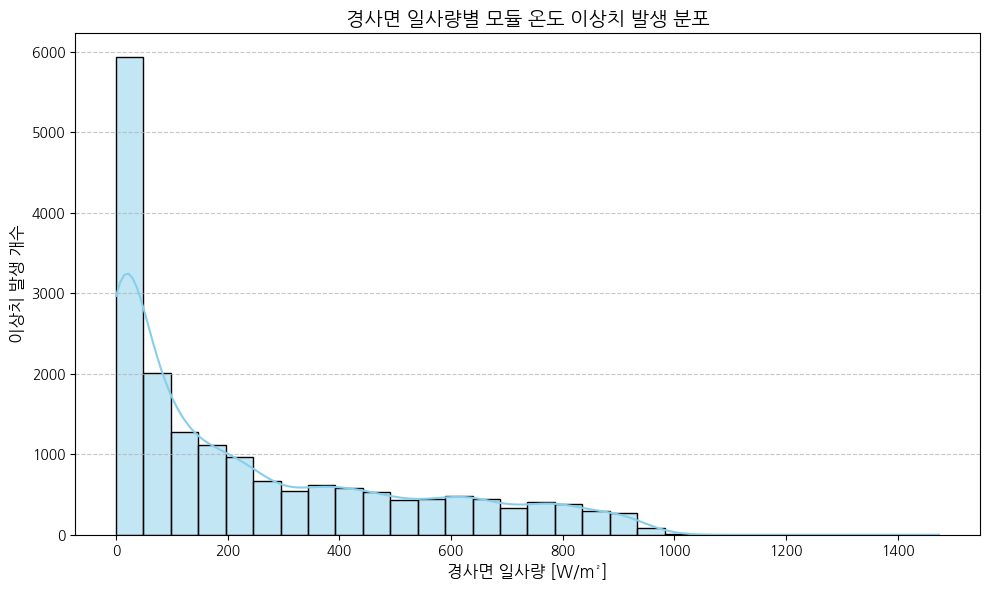

In [ ]:
# 경사면 일사량 분포 시각화
plt.figure(figsize=(10,6))
sns.histplot(df_outliers["경사면일사량"], bins=30, color="skyblue", kde=True)

plt.title("경사면 일사량별 모듈 온도 이상치 발생 분포", fontsize=14)
plt.xlabel("경사면 일사량 [W/m²]", fontsize=12)
plt.ylabel("이상치 발생 개수", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


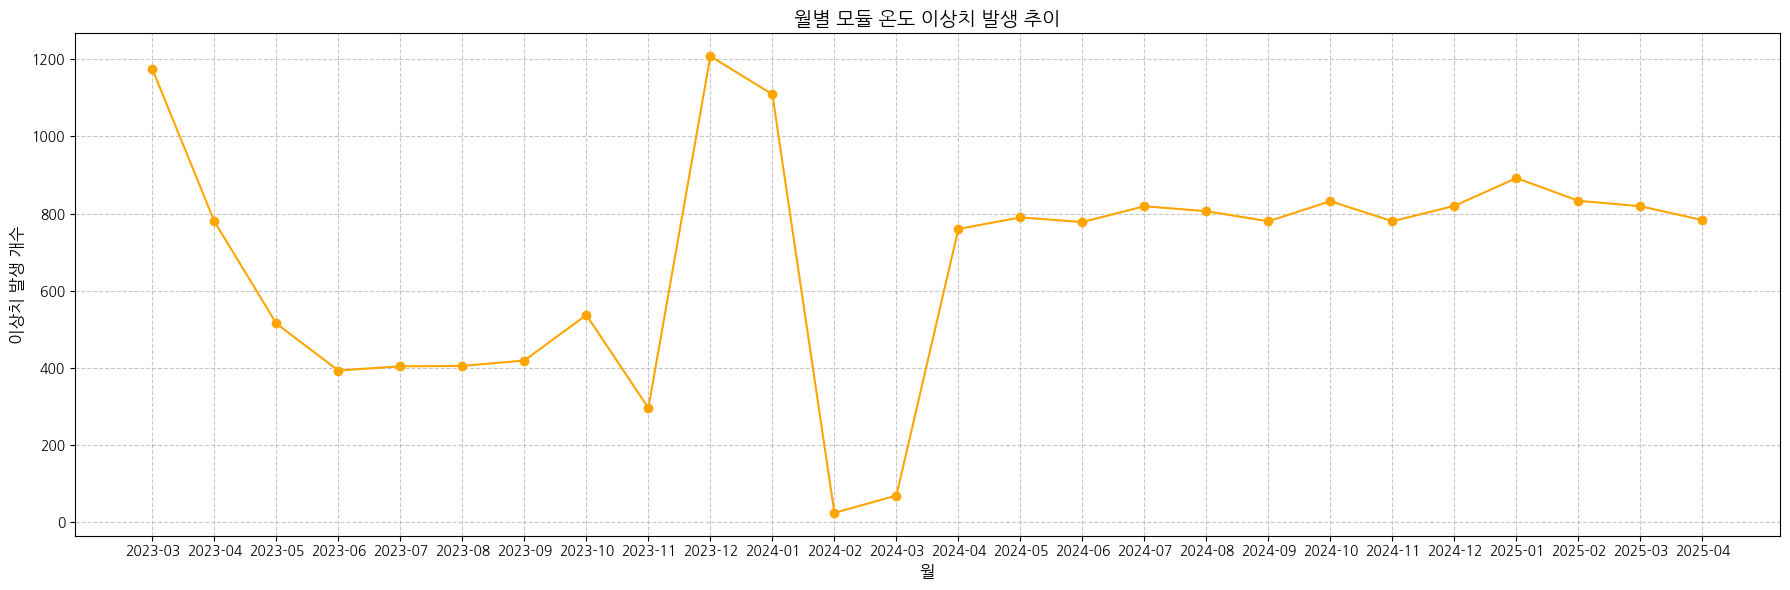

In [ ]:
# Datetime이 datetime 형식이 아닐 경우 변환
df_outliers["Datatime"] = pd.to_datetime(df_outliers["Datatime"])

# 월 컬럼 추가
df_outliers["월"] = df_outliers["Datatime"].dt.to_period("M")

# 월별 이상치 수 계산
df_monthly = df_outliers.groupby("월").size().reset_index(name="이상치_개수")

# 시각화
plt.figure(figsize=(18,6))
plt.plot(df_monthly["월"].astype(str), df_monthly["이상치_개수"], marker='o', color='orange')
plt.title("월별 모듈 온도 이상치 발생 추이", fontsize=14)
plt.xlabel("월", fontsize=12)
plt.ylabel("이상치 발생 개수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **3. 단변량 회귀 VS 다변량 회귀**

In [ ]:
df_srm = df.copy()

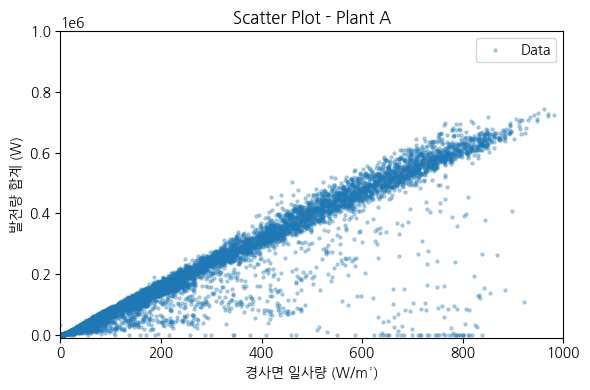

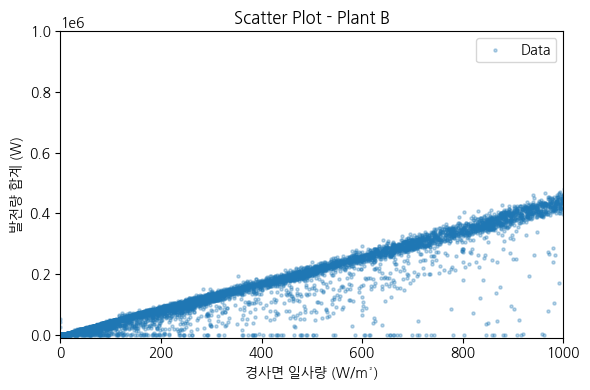

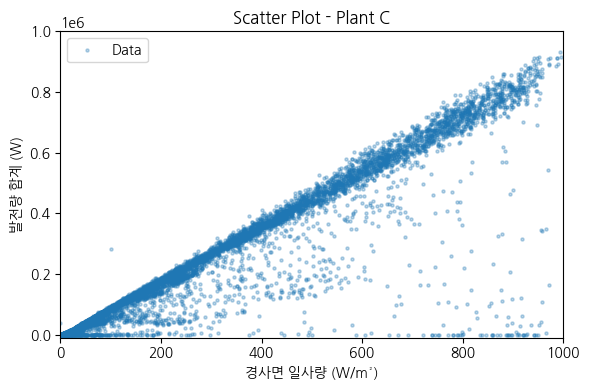

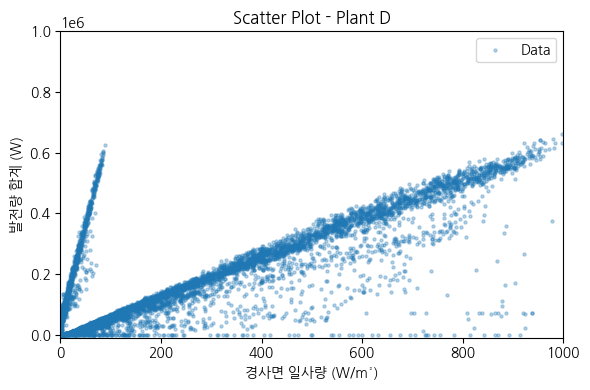

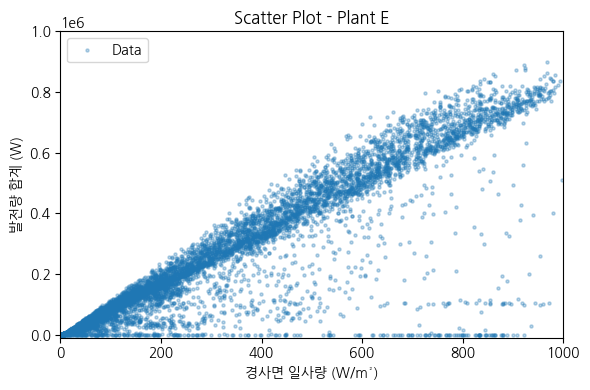

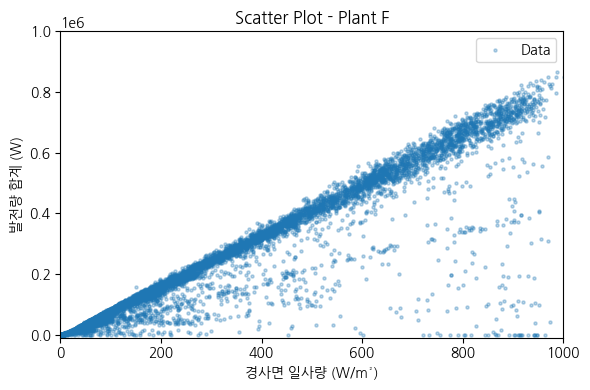

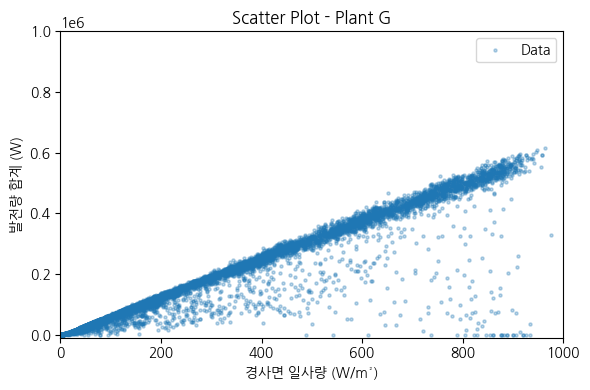

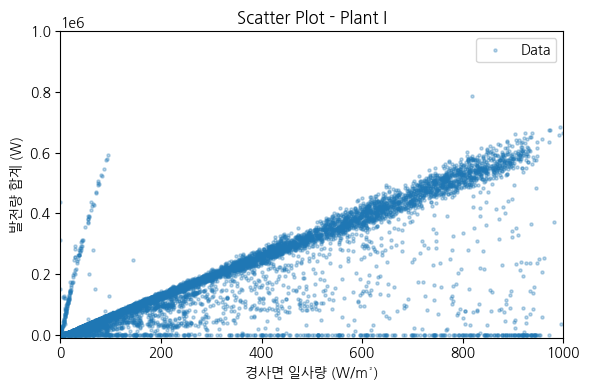

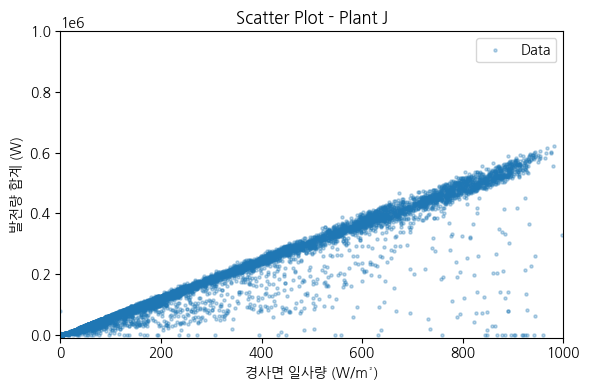

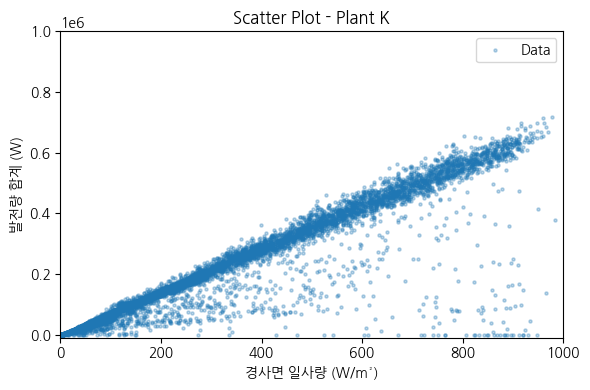

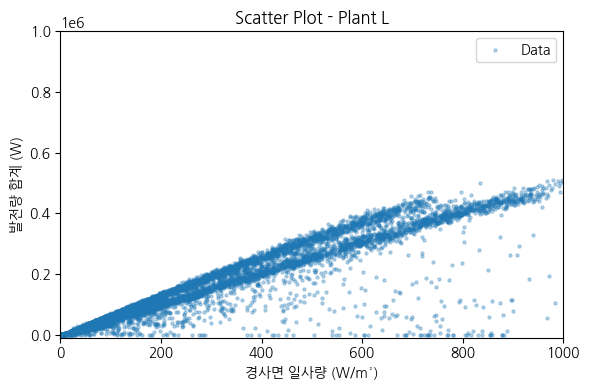

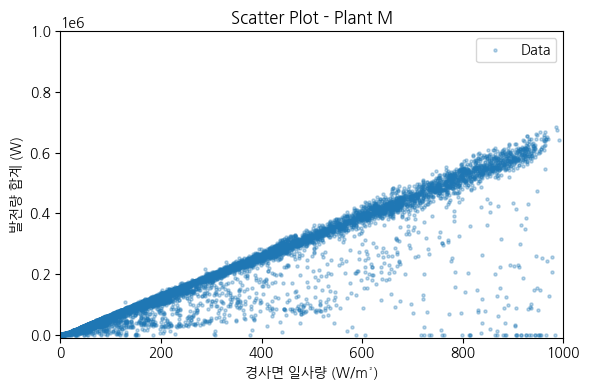

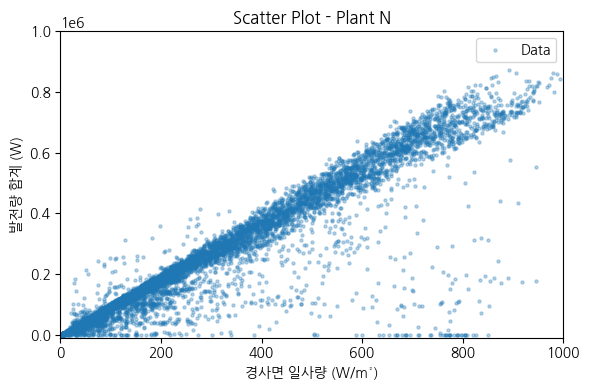

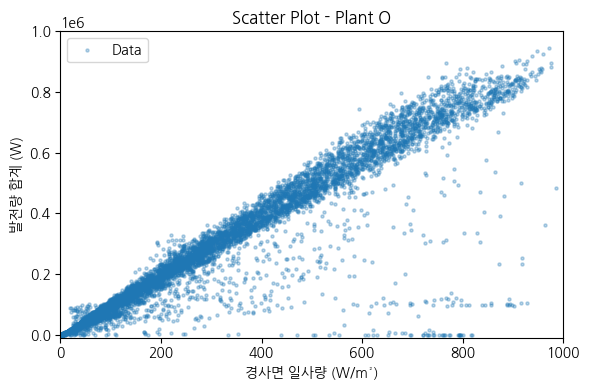

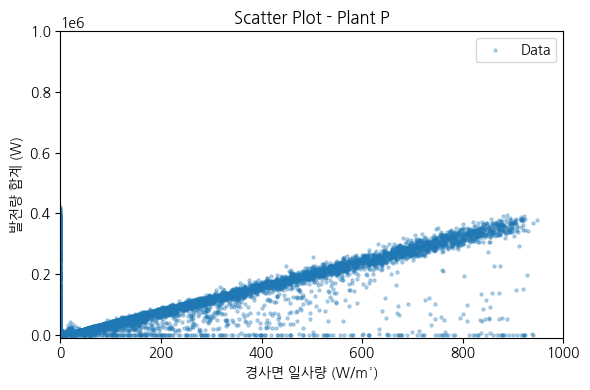

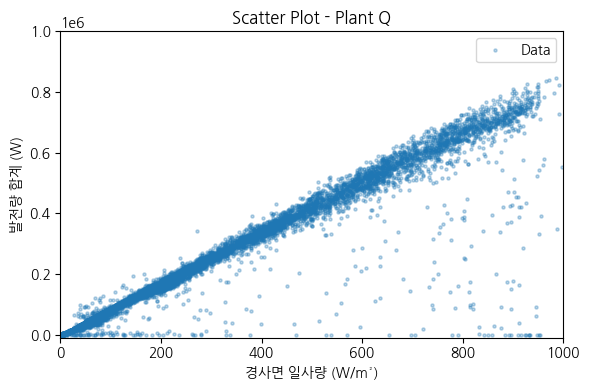

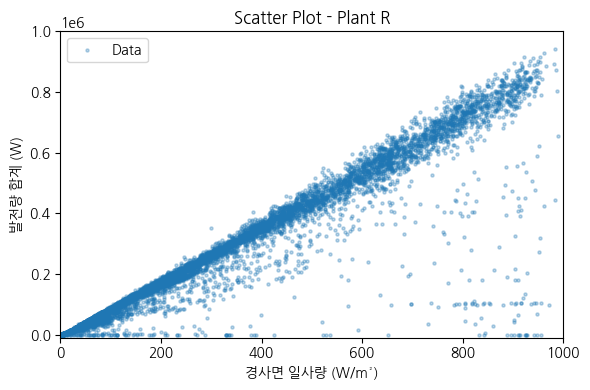

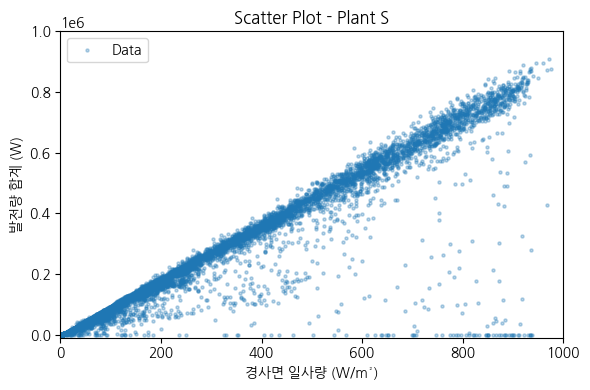

In [ ]:
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # 음수 발전량을 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # X, y
    X = df_p["경사면일사량"]
    y = df_p["발전량합계"]

    # 산점도
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, s=5, alpha=0.3, label="Data")
    plt.title(f"Scatter Plot - Plant {plant}")
    plt.xlabel("경사면 일사량 (W/m²)")
    plt.ylabel("발전량 합계 (W)")
    plt.xlim(0, 1000)  # X축 범위 고정
    plt.ylim(-10000, 1000000)

    plt.legend()
    plt.tight_layout()
    plt.show()

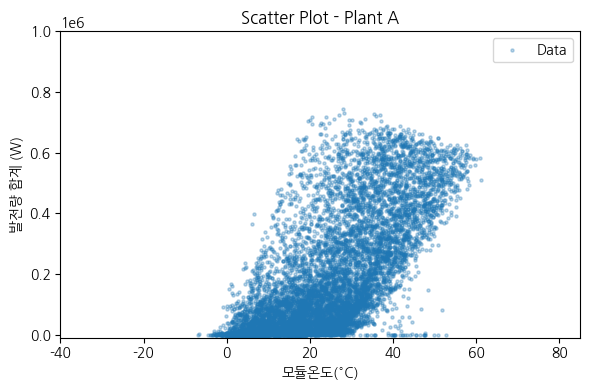

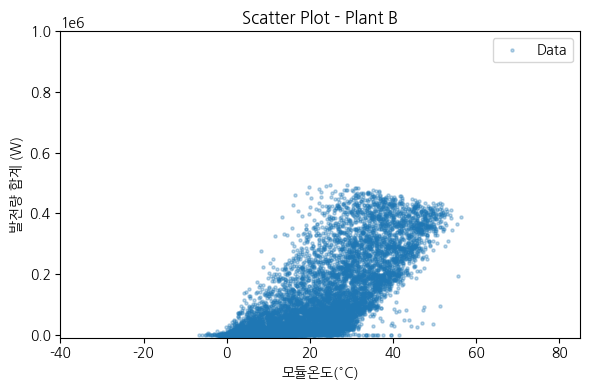

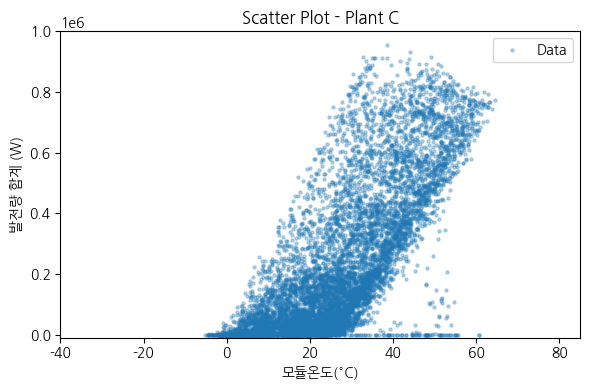

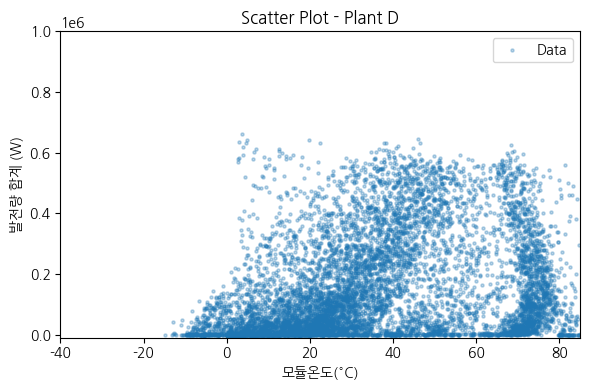

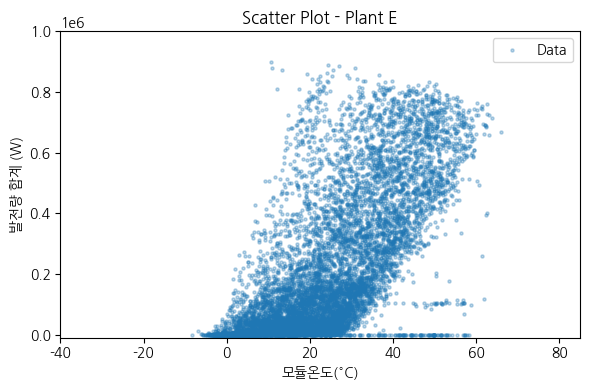

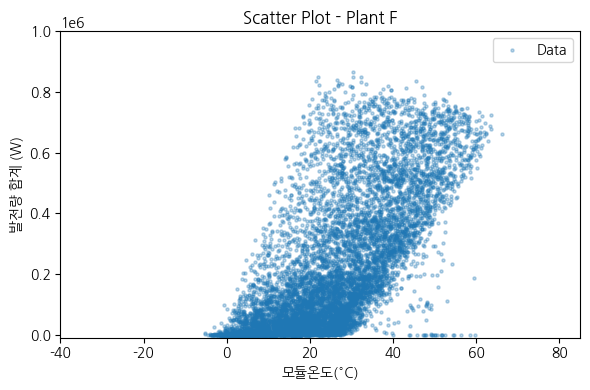

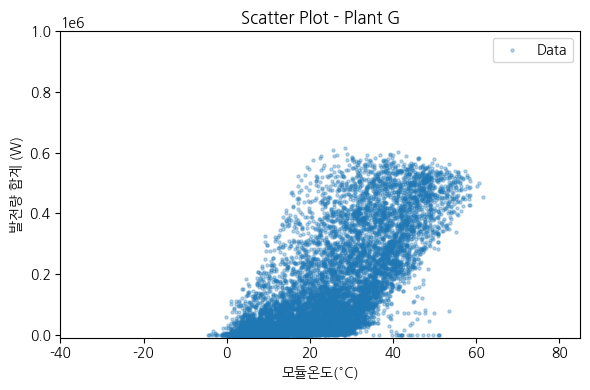

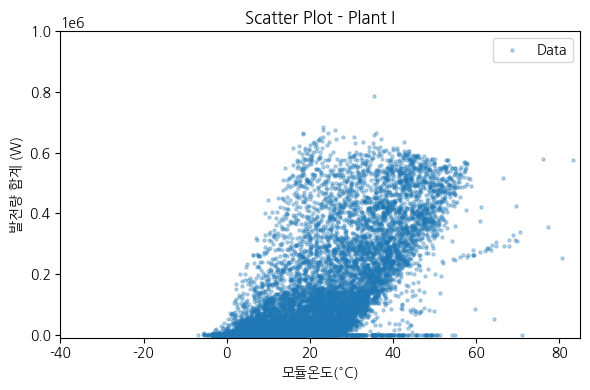

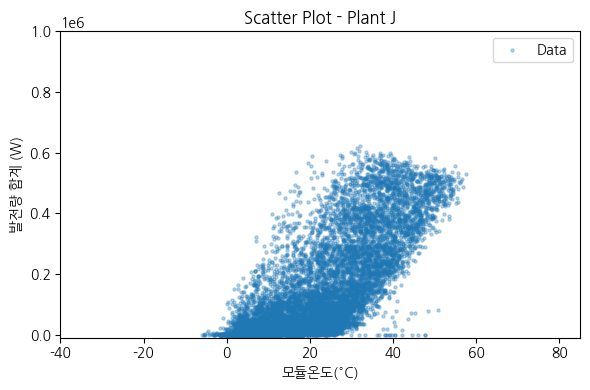

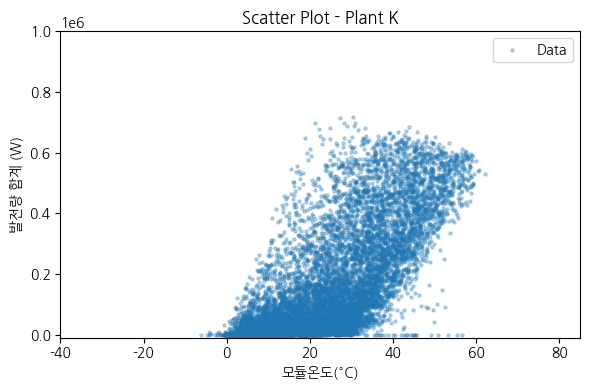

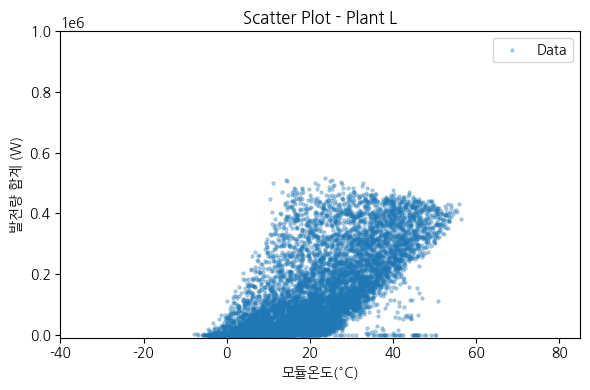

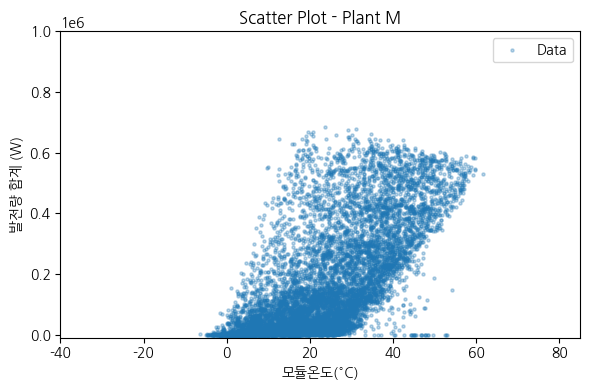

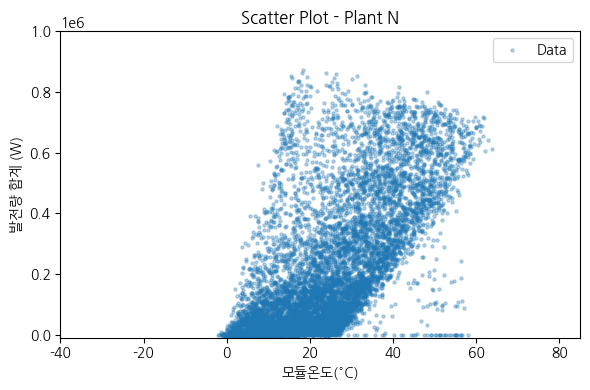

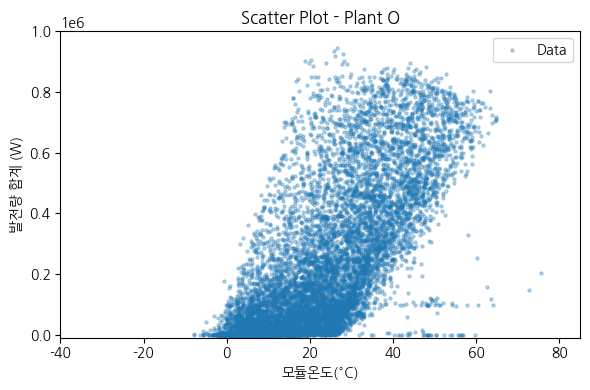

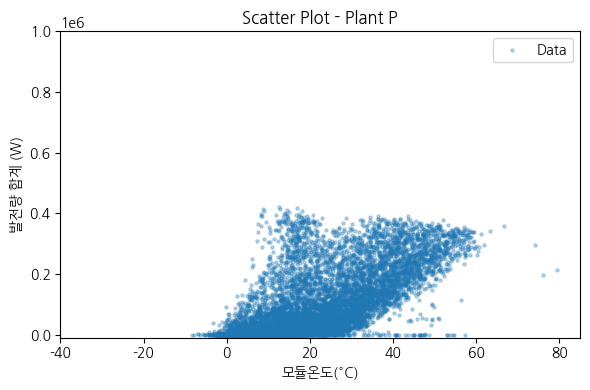

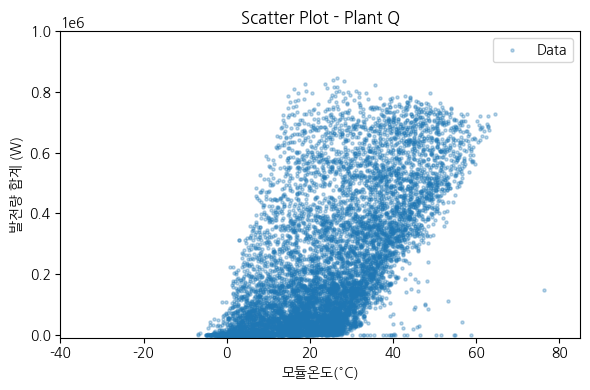

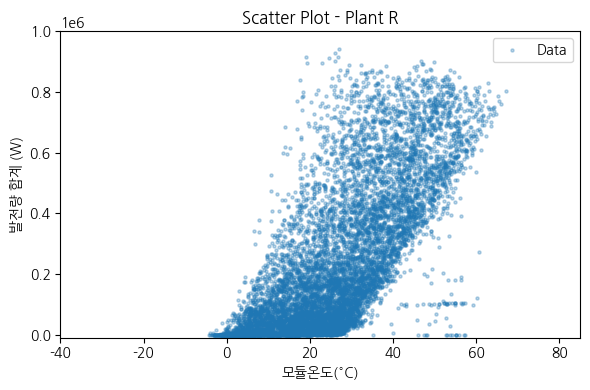

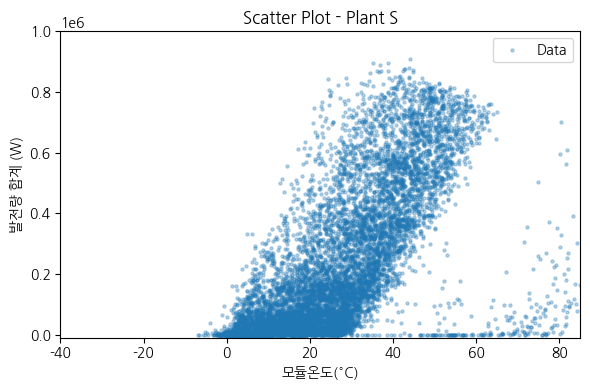

In [ ]:
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # 음수 발전량을 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # X, y
    X = df_p["모듈온도(°C)"]
    y = df_p["발전량합계"]

    # 산점도
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, s=5, alpha=0.3, label="Data")
    plt.title(f"Scatter Plot - Plant {plant}")
    plt.xlabel("모듈온도(°C)")
    plt.ylabel("발전량 합계 (W)")
    plt.xlim(-40, 85)  # X축 범위 고정
    plt.ylim(-10000, 1000000)

    plt.legend()
    plt.tight_layout()
    plt.show()

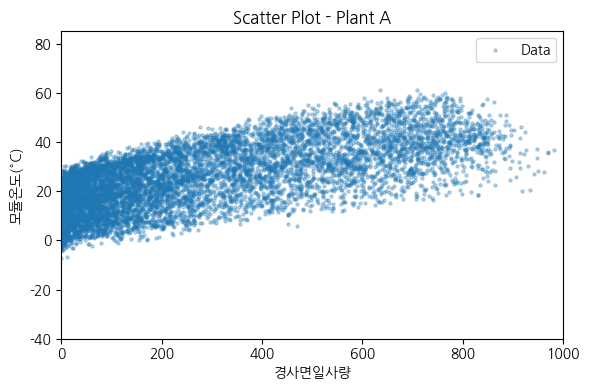

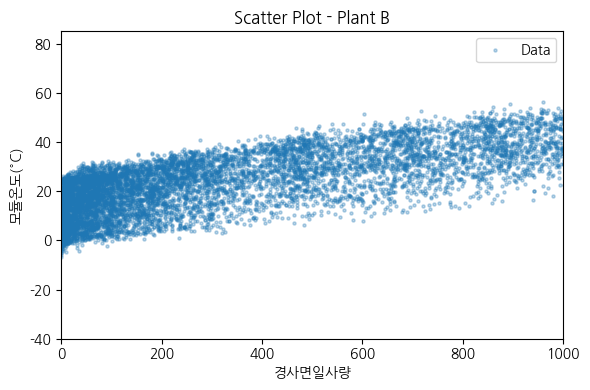

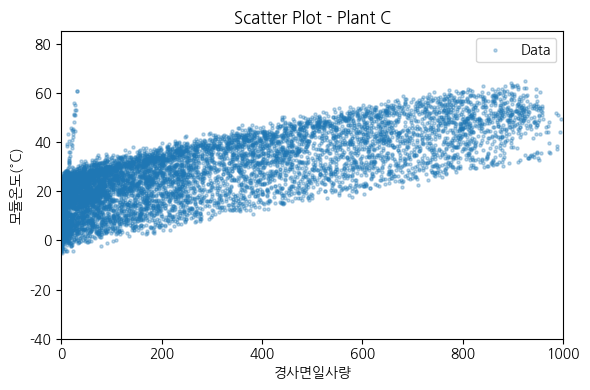

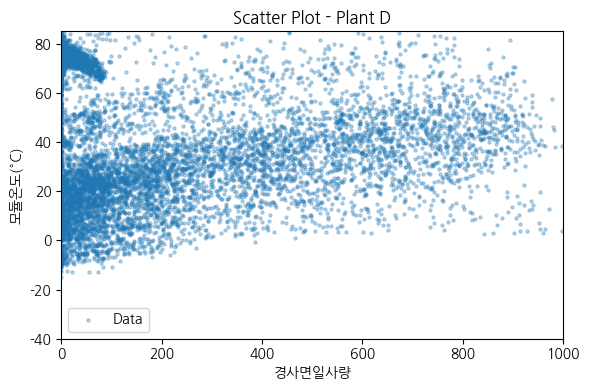

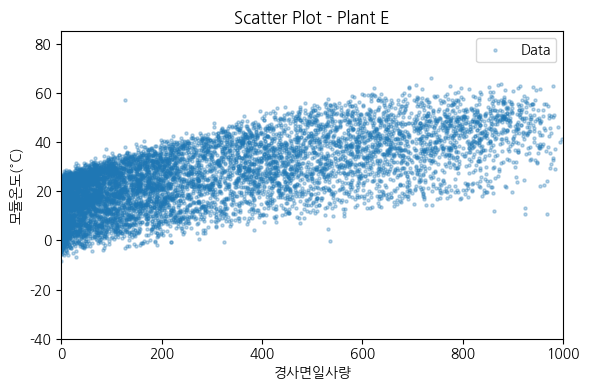

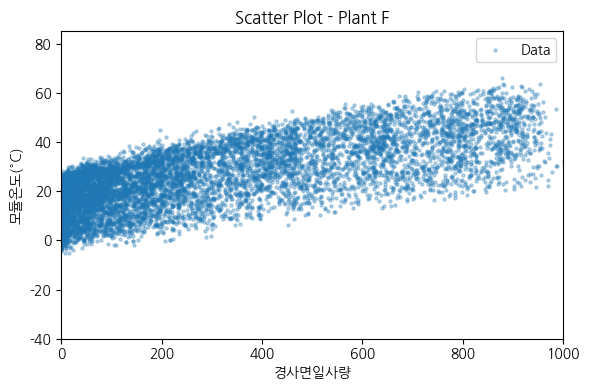

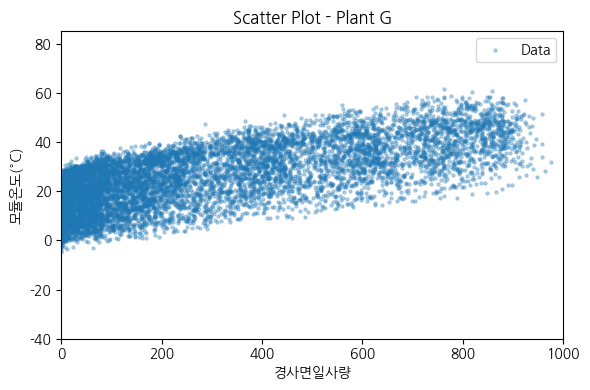

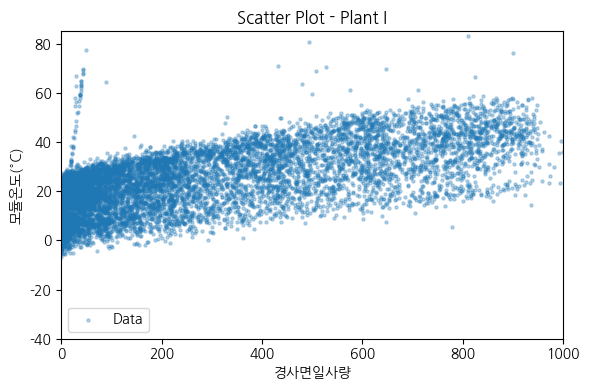

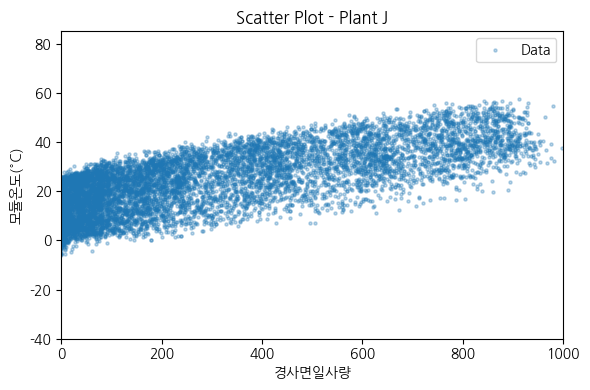

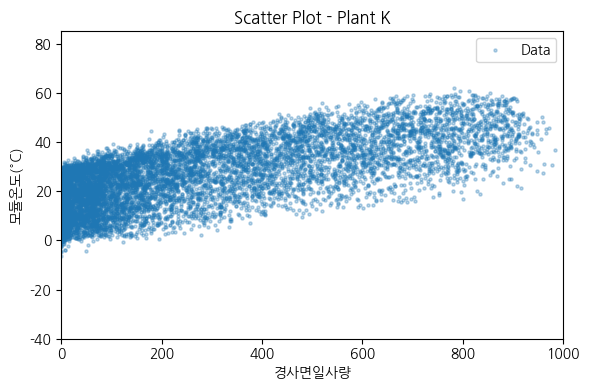

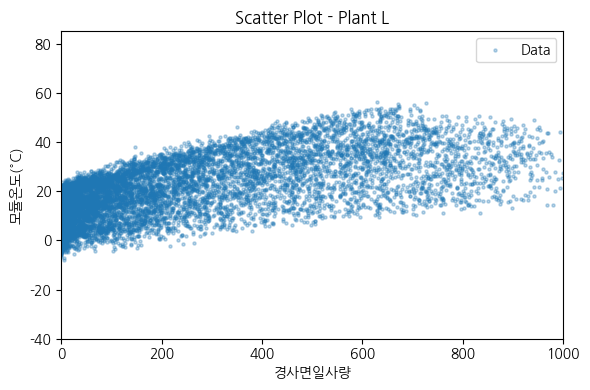

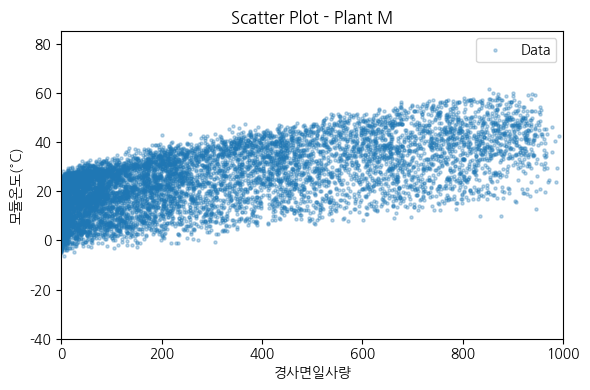

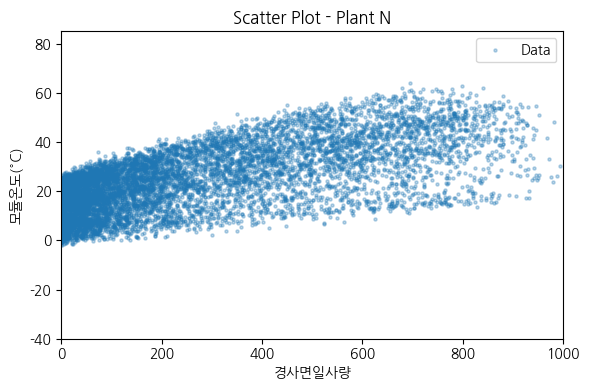

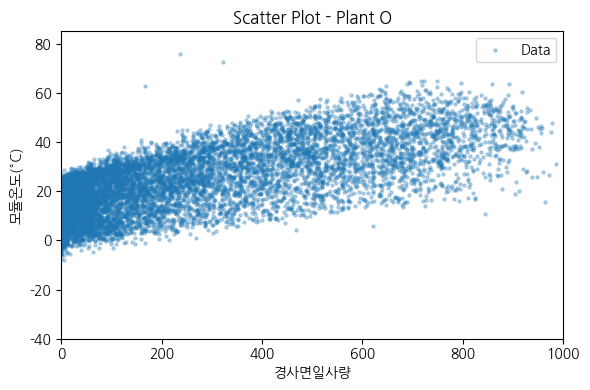

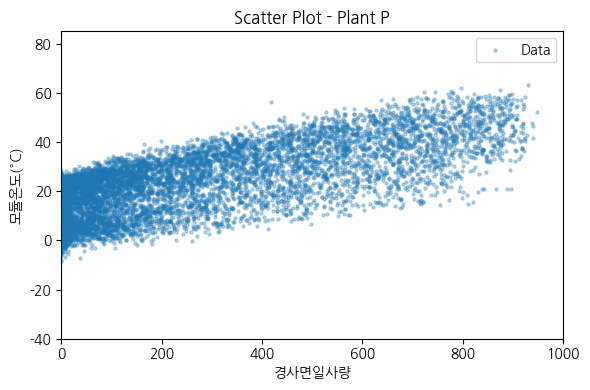

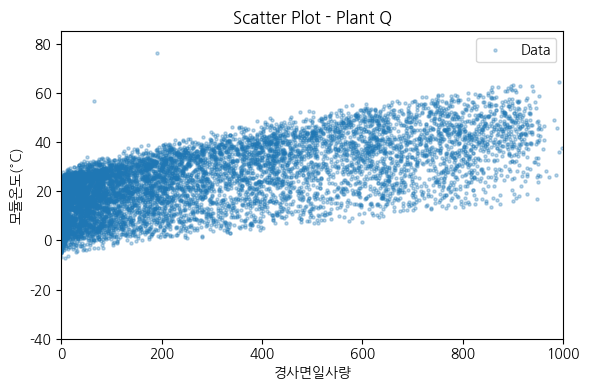

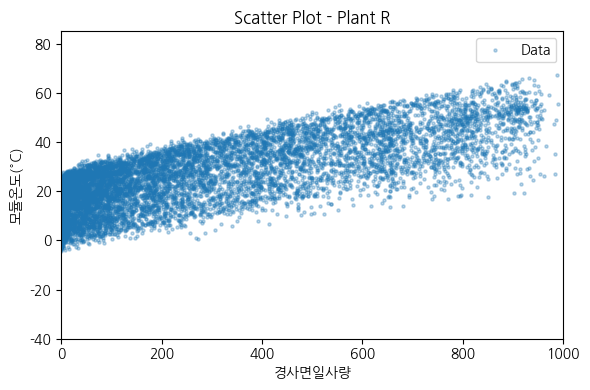

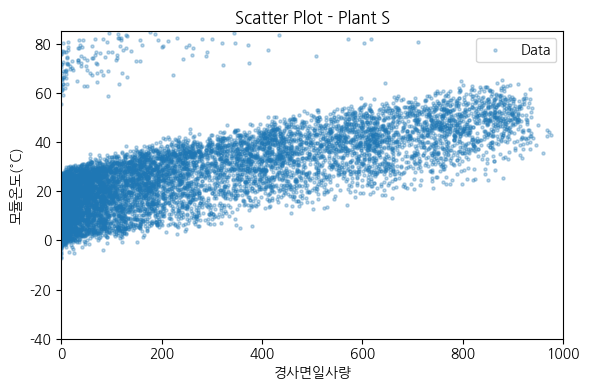

In [ ]:
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # X, y
    X = df_p["경사면일사량"]
    y = df_p["모듈온도(°C)"]

    # 산점도
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, s=5, alpha=0.3, label="Data")
    plt.title(f"Scatter Plot - Plant {plant}")
    plt.xlabel("경사면일사량")
    plt.ylabel("모듈온도(°C)")
    plt.xlim(0, 1000)  # X축 범위 고정
    plt.ylim(-40, 85)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# 모듈온도 -40 ~ 80 범위 이내, 경사면일사량 0 ~ 1000 범위 이내 데이터만 남김
df_srm = df_srm[
    (df_srm["모듈온도(°C)"].between(-40, 80)) &
    (df_srm["경사면일사량"].between(0, 1000))
]


경사면일사량 vs 모듈온도 상관계수 (피어슨): 0.6254066753470883


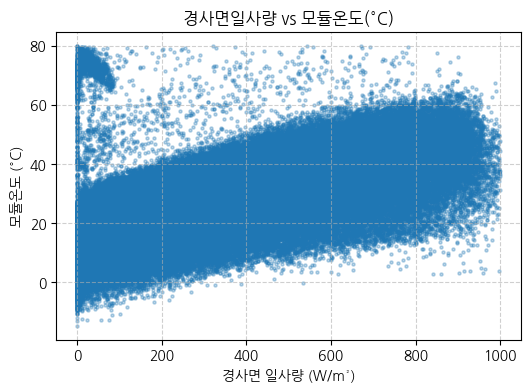

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# df_srm 에는 "경사면일사량", "모듈온도(°C)" 열이 있다고 가정

# 1. 상관계수 계산 (피어슨 상관관계)
corr = df_srm["경사면일사량"].corr(df_srm["모듈온도(°C)"], method="pearson")
print("경사면일사량 vs 모듈온도 상관계수 (피어슨):", corr)

# 2. 산점도 시각화
plt.figure(figsize=(6,4))
plt.scatter(df_srm["경사면일사량"], df_srm["모듈온도(°C)"], s=5, alpha=0.3)
plt.title("경사면일사량 vs 모듈온도(°C)")
plt.xlabel("경사면 일사량 (W/m²)")
plt.ylabel("모듈온도 (°C)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


다변량 함수 관계로 보려 했으나, 모듈 온도가 발전량에 끼치는 영향은 상대적으로 적다 생각하여 경사면일사량과 발전량 합계의 관계로 단순하게 보고자 했음.

이제 R^2 값을 비교하기도 해야할 듯

In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()
results = []

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # 음수 발전량을 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # === (1) 단순 회귀: 경사면일사량만 ===
    X1 = sm.add_constant(df_p["경사면일사량"])
    y = df_p["발전량합계"]

    model1 = sm.OLS(y, X1).fit()
    r2_simple = model1.rsquared

    # === (2) 다중 회귀: 경사면일사량 + 모듈온도 ===
    X2 = df_p[["경사면일사량", "모듈온도(°C)"]]
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(y, X2).fit()
    r2_multiple = model2.rsquared

    # 결과 저장
    results.append({
        "발전소명": plant,
        "R² (일사량만)": round(r2_simple, 4),
        "R² (일사량+온도)": round(r2_multiple, 4),
        "R² 증가량": round(r2_multiple - r2_simple, 4)
    })

# 결과 테이블 보기
df_r2 = pd.DataFrame(results)
print(df_r2)

# (선택) 시각화
plt.figure(figsize=(6,4))
plt.bar(df_r2["발전소명"], df_r2["R² 증가량"])
plt.title("R² 증가량 비교 (일사량 vs 일사량+온도)")
plt.ylabel("ΔR²")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# 4. PR 값 구하기
- PR 값 구하기
- WCPR 값 구하기

두 PR 값 비교하기


In [ ]:
# 먼저 중간 발표 때 사용했던 PR 값 구하기
df_pr = df.copy()

df_pr["re_coefficient"] = 1 + (-0.00394) * (df_pr["모듈온도(°C)"] - 25)
df_pr["effective_irradiance"] = df_pr["경사면일사량"] * df_pr["re_coefficient"]
df_pr["total_inverter_capacity_kW"] = df_pr["정격출력(kWh)"] * df_pr["인버터수량"]
df_pr["reference_energy"] = (df_pr["effective_irradiance"] / 1000 * df_pr["total_inverter_capacity_kW"] * 0.982)
df_pr["PR"] = (df_pr["발전량합계"] / 1000) / df_pr["reference_energy"]
df_pr["PR"].replace([np.inf, -np.inf], np.nan, inplace=True)
df_pr["PR"].fillna(0, inplace=True)

df_pr["PR"]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract month from Datatime
df_pr['month'] = df_pr['Datatime'].dt.month

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x='month', y='PR', data=df_pr,
    showfliers=False,    # 극단치는 제외
    palette='Set3'
)

# 1) 수동으로 범위 지정
ax.set_ylim(0, 1.5)      # Y축을 0~1.2로 잘라서 보여줍니다

plt.title('Monthly PR distribution')
plt.xlabel('Month')
plt.ylabel('Performance Ratio (PR)')
plt.show()
()

In [ ]:
# WCPR 값 구하기
df_wcpr = df.copy()

df_wcpr["total_inverter_capacity_kW"] = df_wcpr["정격출력(kWh)"] * df_wcpr["인버터수량"]
df_wcpr["reference_energy"] = (df_wcpr["경사면일사량"] / 1000 * df_wcpr["total_inverter_capacity_kW"] * 0.982)
df_wcpr["PR"] = (df_wcpr["발전량합계"] / 1000) / df_wcpr["reference_energy"]

df_wcpr.loc[df_wcpr["모듈명"] == "SN390M-37", "PR"] = df_wcpr["PR"] * (1 / (1 + (-0.00350) * (df_wcpr["모듈온도(°C)"].mean() - df_wcpr["모듈온도(°C)"])))
df_wcpr.loc[df_wcpr["모듈명"] == "SN375M-32", "PR"] = df_wcpr["PR"] * (1 / (1 + (-0.00394) * (df_wcpr["모듈온도(°C)"].mean() - df_wcpr["모듈온도(°C)"])))

df_wcpr["PR"].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wcpr["PR"].fillna(0, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract month from Datatime
df_wcpr['month'] = df_wcpr['Datatime'].dt.month

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x='month', y='PR', data=df_wcpr,
    showfliers=False,    # 극단치는 제외
    palette='Set3'
)

# 1) 수동으로 범위 지정
ax.set_ylim(0, 1.5)      # Y축을 0~1.2로 잘라서 보여줍니다

plt.title('Monthly PR distribution')
plt.xlabel('Month')
plt.ylabel('Performance Ratio (PR)')
plt.show()
()

In [ ]:
df["PR"] = df_wcpr["PR"]

# **5. Simple Regression Model 구하기**
simple regression model을 구하기 위해 고장, 고장 의심, 센서 오류와 같은 비정상적인 데이터들을 전부 제외하고 정상인 것들만 model을 구하고 그 모델을 정상인 것들과 비교해서 유효성 검증 후에 scatter plot을 통해 margin을 구하고 비정상과 정상을 구별하기 위한 과정

먼저 df를 복사하여 df_srm을 만들고 여기서 일시적으로 전처리를 진행하기

In [ ]:
df_srm = df.copy()

실행 전에 전체 데이터 셋으로 scatter plot 진행하기

In [ ]:
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # 음수 발전량을 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # X, y
    X = df_p["경사면일사량"]
    y = df_p["발전량합계"]

    # 산점도
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, s=5, alpha=0.3, label="Data")
    plt.title(f"Scatter Plot - Plant {plant}")
    plt.xlabel("경사면 일사량 (W/m²)")
    plt.ylabel("발전량 합계 (W)")
    plt.xlim(0, 1000)  # X축 범위 고정
    plt.ylim(-10000, 1000000)

    plt.legend()
    plt.tight_layout()
    plt.show()


확실하게 고장인 것들은 제외시키고 진행하기

In [ ]:
df_srm = df_srm[(df_srm["PR"] < 1.0) & (df_srm["PR"] > 0)]
# 출력제한, 고장 내역에 있는 것들 전부 제외시키기
df_srm = df_srm[df_srm["출력제한여부"] == 0]
df_srm = df_srm[df_srm["고장내역여부"] == 0]

In [ ]:
import matplotlib.pyplot as plt

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant].copy()

    # 음수 발전량을 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # X, y
    X = df_p["경사면일사량"]
    y = df_p["발전량합계"]

    # 산점도
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, s=5, alpha=0.3, label="Data")
    plt.title(f"Scatter Plot - Plant {plant}")
    plt.xlabel("경사면 일사량 (W/m²)")
    plt.ylabel("발전량 합계 (W)")
    plt.xlim(0, 1000)  # X축 범위 고정
    plt.ylim(-10000, 1000000)

    plt.legend()
    plt.tight_layout()
    plt.show()


**Simple Regression Model Parameters 구하기**

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

results = []

plants = df_srm["발전소명"].unique()

for plant in plants:
    df_p = df_srm[df_srm["발전소명"] == plant]

    # X, y 준비
    X = sm.add_constant(df_p["경사면일사량"])  # 절편항 추가
    y = df_p["발전량합계"]

    # OLS 회귀 적합
    model = sm.OLS(y, X).fit()

    # 결과 저장
    results.append({
        "발전소명": plant,
        "slope": model.params["경사면일사량"],
        "intercept": model.params["const"],
        "R2": model.rsquared,
    })

    # 시각화
    plt.figure(figsize=(6,4))
    plt.scatter(df_p["경사면일사량"], y, s=5, alpha=0.3, label="Data")
    plt.plot(df_p["경사면일사량"], model.predict(X), color="red", linewidth=2, label="Regression Line")
    plt.title(f"Plant {plant} R²={model.rsquared:.3f}")
    plt.xlabel("경사면 일사량 (W/m²)")
    plt.ylabel("발전량 합계 (W)")
    plt.legend()
    plt.xlim(0, 1000)
    plt.ylim(0, 1000000)
    plt.tight_layout()
    plt.show()

# 결과 DataFrame 정리
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


In [ ]:
df_normal = df_srm.copy()

In [ ]:
df_normal = df_normal[(df_normal["경사면일사량"] > 100)]

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, normaltest, skew, kurtosis

plants = df_normal["발전소명"].unique()

for plant in plants:
    df_p = df_normal[df_normal["발전소명"] == plant].copy()

    # 음수 발전량은 0으로 치환
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # X, y 준비
    X = sm.add_constant(df_p["경사면일사량"])
    y = df_p["발전량합계"]

    # OLS 회귀 적합
    model = sm.OLS(y, X).fit()

    # 예측값 및 잔차 계산
    df_p["y_hat"] = model.predict(X)
    df_p["residual"] = df_p["발전량합계"] - df_p["y_hat"]

    residuals = df_p["residual"].dropna()

    # --------------------------
    # 상하 3% 극단값 제거
    # --------------------------
    lower_q = residuals.quantile(0.05)
    upper_q = residuals.quantile(0.95)
    residuals_trimmed = residuals[(residuals >= lower_q) & (residuals <= upper_q)]

    # --------------------------
    # 정규분포 관련 통계량 계산
    # --------------------------
    mu = np.mean(residuals_trimmed)
    sigma = np.std(residuals_trimmed)
    skewness = skew(residuals_trimmed)
    kurt = kurtosis(residuals_trimmed)

    # --------------------------
    # 출력 요약
    # --------------------------
    print(f"\n🌿 발전소: {plant}")
    print(f"  평균 μ = {mu:.2f}, 표준편차 σ = {sigma:.2f}")
    print(f"  왜도 Skewness = {skewness:.3f}, 첨도 Kurtosis = {kurt:.3f}")
    print(f"  (상하 3% 극단값 제거: {lower_q:.1f} ~ {upper_q:.1f})")

    # --------------------------
    # 히스토그램 시각화
    # --------------------------
    plt.figure(figsize=(8,5))
    plt.hist(residuals_trimmed, bins=40, density=True, alpha=0.6, color='gray')
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label='Normal PDF')
    plt.title(f"{plant} - 잔차 분포")
    plt.xlabel("Residual (W)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

outliers_list = []

k = 3  # 표준편차 배수 (99.7% 수준)
for plant in plants:
    df_p = df[df["발전소명"] == plant].copy()

    # --- 음수 발전량합계 처리 ---
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # 회귀계수 불러오기 (이미 구해둔 results 활용)
    slope = next(r["slope"] for r in results if r["발전소명"] == plant)
    intercept = next(r["intercept"] for r in results if r["발전소명"] == plant)

    # baseline 예측값
    y_hat = intercept + slope * df_p["경사면일사량"]

    # 잔차
    residuals = df_p["발전량합계"] - y_hat

    # --- Margin 방법 A: 표준편차 ---
    sigma = residuals.std()
    margin_low_std = y_hat - k * sigma
    margin_high_std = y_hat + k * sigma

    # --- Margin 방법 B: 분위수 ---
    q_low = np.quantile(residuals, 0.05)
    q_high = np.quantile(residuals, 0.95)
    margin_low_q = y_hat + q_low
    margin_high_q = y_hat + q_high

    # Margin 밖 데이터 (표준편차 기준)
    mask_outlier = (df_p["발전량합계"] < margin_low_std) | (df_p["발전량합계"] > margin_high_std)
    df_out = df_p.loc[mask_outlier, ["Datatime", "발전소명", "경사면일사량", "INV0001_발전량", "INV0002_발전량", "발전량합계", "태양고도",
                           "습도(%)", "강수량(mm)", "풍속(m/s)", "온도", "외기온도(°C)", "모듈온도(°C)", ]].copy()
    outliers_list.append(df_out)

    # --- 시각화 ---
    plt.figure(figsize=(8, 5))
    plt.scatter(df_p["경사면일사량"], df_p["발전량합계"], s=10, alpha=0.5, label="실제 데이터")
    plt.plot(df_p["경사면일사량"], y_hat, color="red", label="Baseline (OLS)")
    plt.plot(df_p["경사면일사량"], margin_low_std, color="green", linestyle="--", label="Margin Low (σ)")
    plt.plot(df_p["경사면일사량"], margin_high_std, color="green", linestyle="--", label="Margin High (σ)")
    plt.title(f"{plant} - Simple Regression 기반 Margin")
    plt.xlabel("경사면일사량 [W/m²]")
    plt.ylabel("발전량합계 [kWh]")
    plt.xlim(0,1000)
    plt.ylim(0,1000000)
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd

# 반복문 끝난 뒤에 추가
outliers_first = pd.concat(outliers_list, ignore_index=True)

# 엑셀 파일로 저장
outliers_first.to_excel("Margin_이상치_일차_통합.xlsx", index=False)
print("✅ Margin 밖 데이터가 'Margin_이상치_일차_통합.xlsx' 파일로 저장되었습니다.")


# **6. Margin 밖에 있는 점들을 분석해서 simple regression model 정교화하기(1차)**

In [ ]:
outliers_first

# **7. 전체 데이터와 비교해서 진행**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 결과 저장용 리스트
all_outliers_list = []

# 표준편차 배수 (3σ = 약 99.7%)
k = 3

# 발전소별 margin 계산
for _, row in df_results.iterrows():
    plant = row["발전소명"]
    slope = row["slope"]
    intercept = row["intercept"]

    # 발전소별 데이터 필터
    df_p = df[df["발전소명"] == plant].copy()

    # 음수 발전량 0 처리
    df_p.loc[df_p["발전량합계"] < 0, "발전량합계"] = 0

    # baseline 예측값 (ŷ)
    df_p["y_hat"] = intercept + slope * df_p["경사면일사량"]

    # 잔차
    df_p["residual"] = df_p["발전량합계"] - df_p["y_hat"]

    # 표준편차 기반 margin
    sigma = df_p["residual"].std()
    df_p["margin_low"] = df_p["y_hat"] - k * sigma
    df_p["margin_high"] = df_p["y_hat"] + k * sigma

    # margin 밖의 데이터 → 이상치
    mask_out = (df_p["발전량합계"] < df_p["margin_low"]) | (df_p["발전량합계"] > df_p["margin_high"])
    df_out = df_p.loc[mask_out, [
        "Datatime", "발전소명", "모델명", "인버터수량", "정격출력(kWh)", "모듈명" ,"경사면일사량", "발전량합계",
        "외기온도(°C)", "모듈온도(°C)", "습도(%)","태양고도", "풍속(m/s)", "온도", "출력제한여부", "고장내역여부"
    ]].copy()

    df_out["plant_sigma"] = sigma  # 참고용으로 표준편차도 저장
    df_out["slope"] = slope
    df_out["intercept"] = intercept
    all_outliers_list.append(df_out)

    # 시각화 (선택)
    plt.figure(figsize=(8, 5))
    plt.scatter(df_p["경사면일사량"], df_p["발전량합계"], s=5, alpha=0.3, label="데이터")
    plt.plot(df_p["경사면일사량"], df_p["y_hat"], color="blue", label="Baseline")
    plt.plot(df_p["경사면일사량"], df_p["margin_low"], color="red", linestyle="--", label="Low (3σ)")
    plt.plot(df_p["경사면일사량"], df_p["margin_high"], color="red", linestyle="--", label="High (3σ)")
    plt.title(f"{plant} - Margin 기반 이상치 검출")
    plt.xlabel("경사면 일사량 (W/m²)")
    plt.ylabel("발전량합계 (W)")
    plt.legend()
    plt.xlim(0,1000)
    plt.ylim(0,1000000)
    plt.tight_layout()
    plt.show()

# 발전소별 이상치 통합 저장
df_outliers_all = pd.concat(all_outliers_list, ignore_index=True)


In [ ]:
# 1️⃣ all_outliers_list 합쳐서 하나의 DataFrame으로
df_outliers_all = pd.concat(all_outliers_list, ignore_index=True)

# 2️⃣ df에 '이상감지' 컬럼 추가
df["이상감지"] = 0  # 기본값은 정상(0)

# 3️⃣ df_outliers_all에 포함된 행만 1로 라벨링
# Datatime과 발전소명을 기준으로 매칭 (또는 고유 index 기준으로도 가능)
df.loc[
    df.set_index(["Datatime", "발전소명"]).index.isin(
        df_outliers_all.set_index(["Datatime", "발전소명"]).index
    ),
    "이상감지"
] = 1

# 4️⃣ 결과 확인
print(df["이상감지"].value_counts())
print("✅ 이상감지 라벨링 완료 (0=정상, 1=이상)")

# 💾 엑셀 파일로 저장
save_path = "이상감지 후 최종 df 파일.xlsx"
df.to_excel(save_path, index=False)
print(f"📁 파일 저장 완료: {save_path}")


# **8. Margin 밖에 있는 것들과 비교해서 최종 insight 도출하기**

In [ ]:
df

In [ ]:
summary = df.groupby("발전소명")["이상감지"].agg(['count','sum'])
summary["이상치비율(%)"] = (summary["sum"]/summary["count"]*100).round(2)
summary.rename(columns={"count":"전체데이터수","sum":"이상치수"}, inplace=True)
summary.sort_values("이상치비율(%)", ascending=False)

In [ ]:
df["Datetime"] = pd.to_datetime(df["Datatime"])
df["hour"] = df["Datatime"].dt.hour

hourly = df.groupby("hour")["이상감지"].mean()*100
hourly.plot(kind="bar", figsize=(10,5), title="시간대별 이상치 비율(%)")

In [ ]:
df = df.sort_values(["발전소명", "Datetime"])
df["이전이상"] = df.groupby("발전소명")["이상감지"].shift(1)
df["연속이상"] = (df["이상감지"]==1) & (df["이전이상"]==1)

continuous_counts = df.groupby("발전소명")["연속이상"].sum()
print(continuous_counts)


In [ ]:
# 발전소 A 데이터만 추출
df_A = df[df["발전소명"] == "A"].copy()

# 조건: 이상감지 == 1 & 출력제한여부 == 0
df_A_filtered = df_A[(df_A["이상감지"] == 1) & (df_A["출력제한여부"] == 0)].copy()

# 결과 미리보기
print(f"발전소 A 전체 데이터 수: {len(df_A)}")
print(f"발전소 A 중 이상감지=1 & 출력제한=0 데이터 수: {len(df_A_filtered)}\n")
df_A_filtered.head(20)


In [ ]:
# 기본 통계 비교
stats = df_A_filtered[["INV0001_발전량", "INV0002_발전량"]].describe().T
print(stats)


In [ ]:
import matplotlib.pyplot as plt

# Datetime 형식 변환 (혹시 문자열일 경우 대비)
df_A_filtered["Datetime"] = pd.to_datetime(df_A_filtered["Datetime"])

# Datetime 기준으로 정렬
df_A_filtered = df_A_filtered.sort_values("Datetime")

# 시계열 그래프
plt.figure(figsize=(14,6))
plt.plot(df_A_filtered["Datetime"], df_A_filtered["INV0001_발전량"], label="INV0001 발전량", color="blue")
plt.plot(df_A_filtered["Datetime"], df_A_filtered["INV0002_발전량"], label="INV0002 발전량", color="orange")

plt.title("발전소 A - 인버터별 발전량 시계열 비교 (이상감지=1 & 출력제한=0)")
plt.xlabel("시간")
plt.ylabel("발전량 [kWh]")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 이상감지 = 1인 데이터만 필터링
df_anomaly = df[df['이상감지'] == 1].copy()

# 연-월(YYYY-MM) 단위 컬럼 생성
df_anomaly['연월'] = df_anomaly['Datatime'].dt.to_period('M').astype(str)

# 발전소명별 연-월 이상감지 건수 집계
monthly_counts = (
    df_anomaly
    .groupby(['발전소명', '연월'])
    .size()
    .reset_index(name='이상감지건수')
)

# 발전소 목록
plants = monthly_counts['발전소명'].unique()

# 발전소별 월간 이상감지 추이 시각화
for plant in plants:
    df_p = monthly_counts[monthly_counts['발전소명'] == plant]
    plt.figure(figsize=(8,4))
    plt.plot(df_p['연월'], df_p['이상감지건수'], marker='o')
    plt.title(f'{plant} 월별 이상감지 건수')
    plt.xlabel('연-월')
    plt.ylabel('이상감지 건수')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# (선택) 모든 발전소를 한 그래프에 비교하고 싶을 때
plt.figure(figsize=(10,6))
for plant in plants:
    df_p = monthly_counts[monthly_counts['발전소명'] == plant]
    plt.plot(df_p['연월'], df_p['이상감지건수'], marker='o', label=plant)

plt.title('발전소별 월간 이상감지 추이 비교 (연도 포함)')
plt.xlabel('연-월')
plt.ylabel('이상감지 건수')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 연-월(YYYY-MM) 단위 컬럼 생성
df_anomaly['연월'] = df_anomaly['Datatime'].dt.to_period('M').astype(str)

# 발전소별 연-월 이상감지 건수 집계
monthly_counts = (
    df_anomaly
    .groupby(['발전소명', '연월'])
    .size()
    .reset_index(name='이상감지건수')
)

# 전체 발전소 통합 (모든 발전소 합산)
total_monthly = (
    df_anomaly
    .groupby('연월')
    .size()
    .reset_index(name='이상감지건수')
)

# 발전소 목록
plants = monthly_counts['발전소명'].unique()

# ✅ [1] 전체 발전소 통합 월간 이상감지 추이
plt.figure(figsize=(10,5))
plt.plot(total_monthly['연월'], total_monthly['이상감지건수'], marker='o', color='black')
plt.title('전체 발전소 월간 이상감지 추이')
plt.xlabel('연-월')
plt.ylabel('이상감지 건수')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✅ [2] 발전소별 월간 이상감지 추이 (개별 그래프)
for plant in plants:
    df_p = monthly_counts[monthly_counts['발전소명'] == plant]
    plt.figure(figsize=(8,4))
    plt.plot(df_p['연월'], df_p['이상감지건수'], marker='o')
    plt.title(f'{plant} 월별 이상감지 건수')
    plt.xlabel('연-월')
    plt.ylabel('이상감지 건수')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ✅ [3] 발전소별 월간 이상감지 추이 비교 (한 그래프에)
plt.figure(figsize=(10,6))
for plant in plants:
    df_p = monthly_counts[monthly_counts['발전소명'] == plant]
    plt.plot(df_p['연월'], df_p['이상감지건수'], marker='o', label=plant)

plt.title('발전소별 월간 이상감지 추이 비교 (연도 포함)')
plt.xlabel('연-월')
plt.ylabel('이상감지 건수')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Datatime을 datetime으로 변환
df['Datatime'] = pd.to_datetime(df['Datatime'])

# 기준일 설정
cutoff = pd.Timestamp('2024-06-02')

# 이상감지 데이터만 필터링
df_anomaly = df[df['이상감지'] == 1].copy()

# --------------------------
# ① 2024-06-02 이전 구간
# --------------------------
before_cut = df_anomaly[df_anomaly['Datatime'] <= cutoff]
before_total = len(before_cut)
before_output_limited = len(before_cut[before_cut['출력제한여부'] == 1])

# 비율 계산
before_ratio = (before_output_limited / before_total * 100) if before_total > 0 else 0

# --------------------------
# ② 2024-06-03 이후 구간
# --------------------------
after_cut = df_anomaly[df_anomaly['Datatime'] > cutoff]
after_total = len(after_cut)
after_non_limited = len(after_cut[after_cut['출력제한여부'] != 1])  # ✅ 수정됨

# 비율 계산
after_ratio = (after_non_limited / after_total * 100) if after_total > 0 else 0

# --------------------------
# 결과 출력
# --------------------------
print("✅ 2024-06-02 이전 구간")
print(f"이상감지 건수: {before_total:,}")
print(f"출력제한 여부 = 1 건수: {before_output_limited:,}")
print(f"비율: {before_ratio:.2f}%\n")

print("✅ 2024-06-03 이후 구간")
print(f"이상감지 건수: {after_total:,}")
print(f"출력제한 여부 != 1 건수: {after_non_limited:,}")
print(f"비율: {after_ratio:.2f}%")
